In [9]:
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

# Lập trình cho soft-margin SVM 
Tìm nghiệm cho một bài toán soft-margin SVM bằng ba cách khác nhau: 
* Thông qua bài toán đối ngẫu 
* Bài toán soft-margin SVM không ràng buộc với hàm hinge loss 
* Thư viện sklearn 

## Tạo hai lớp dữ liệu trong không gian hai chiều 

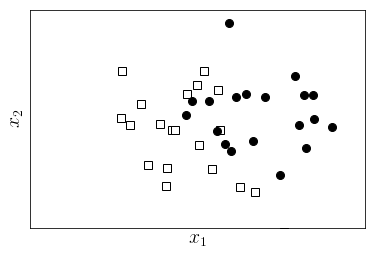

In [10]:
from __future__ import print_function
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
np.random.seed(22)

means = [[2, 2], [4, 2]]
cov = [[.7, 0], [0, .7]]
N = 20
X0 = np.random.multivariate_normal(means[0], cov, N) # each row is a data point 
X1 = np.random.multivariate_normal(means[1], cov, N)
X = np.concatenate((X0, X1))
y = np.concatenate((np.ones(N), -np.ones(N)))

plt.plot(X0[:, 0], X0[:, 1], 'ws', mec ='k', markersize = 8, alpha = 1)
plt.plot(X1[:, 0], X1[:, 1], 'ko', markersize = 8, alpha = 1)
plt.axis('equal')
plt.ylim(0, 4)
plt.xlim(0, 5)

# hide tikcs 
cur_axes = plt.gca()
cur_axes.axes.get_xaxis().set_ticks([])
cur_axes.axes.get_yaxis().set_ticks([])

plt.xlabel('$x_1$', fontsize = 20)
plt.ylabel('$x_2$', fontsize = 20)
## uncomment the next 2 lines to save the plot 
# with PdfPages('data.pdf') as pdf:
#     pdf.savefig()

plt.show()

# Solving by sklearn

In [11]:
from sklearn.svm import SVC
C = 100 # lambda = 0.01
clf = SVC(kernel = 'linear', C = C)
clf.fit(X, y) 

w_sklearn = clf.coef_.reshape(-1, 1)
b_sklearn = clf.intercept_[0]

print('w_sklearn = ', w_sklearn.T)
print('b_sklearn = ', b_sklearn)

w_sklearn =  [[-1.87461946 -1.80697358]]
b_sklearn =  8.496911901960104


# By dual problems

In [12]:
from cvxopt import matrix, solvers
# build K
V = np.concatenate((X0, -X1), axis = 0) # V[n,:] = y[n]*X[n]
K = matrix(V.dot(V.T))
p = matrix(-np.ones((2*N, 1)))
# build A, b, G, h 
G = matrix(np.vstack((-np.eye(2*N), np.eye(2*N))))

h = np.vstack((np.zeros((2*N, 1)), C*np.ones((2*N, 1))))
h = matrix(np.vstack((np.zeros((2*N, 1)), C*np.ones((2*N, 1)))))
A = matrix(y.reshape((-1, 2*N))) 
b = matrix(np.zeros((1, 1))) 
solvers.options['show_progress'] = False
sol = solvers.qp(K, p, G, h, A, b)

l = np.array(sol['x']).reshape(2*N) # lambda vector 

# support set 
S = np.where(l > 1e-5)[0] 
S2 = np.where(l < .999*C)[0]
# margin set 
M = [val for val in S if val in S2] # intersection of two lists

VS = V[S]           # shape (NS, d)
lS = l[S]           # shape (NS,)
w_dual = lS.dot(VS) # shape (d,)
yM = y[M]           # shape(NM,)
XM = X[M]           # shape(NM, d)
b_dual = np.mean(yM - XM.dot(w_dual)) # shape (1,)
print('w_dual = ', w_dual)
print('b_dual = ', b_dual)


w_dual =  [-1.87457279 -1.80695039]
b_dual =  8.496721098153419


# Solving by Hinge loss

In [13]:
lam = 1./C 
def loss(X, y, w, b): 
    """
    X.shape = (2N, d), y.shape = (2N,), w.shape = (d,), b is a scalar 
    """
    z = X.dot(w) + b # shape (2N,)
    yz = y*z
    return (np.sum(np.maximum(0, 1 - yz)) + .5*lam*w.dot(w))/X.shape[0]

def grad(X, y, w, b):
    z = X.dot(w) + b # shape (2N,)
    yz = y*z         # element wise product, shape (2N,)
    active_set = np.where(yz <= 1)[0] # consider 1 - yz >= 0 only 
    _yX = - X*y[:, np.newaxis]   # each row is y_n*x_n 
    grad_w = (np.sum(_yX[active_set], axis = 0) + lam*w)/X.shape[0]
    grad_b = (-np.sum(y[active_set]))/X.shape[0]
    return (grad_w, grad_b)
    

In [14]:
def num_grad(X, y, w, b):
    eps = 1e-10
    gw = np.zeros_like(w)
    gb = 0
    for i in xrange(len(w)):
        wp = w.copy()
        wm = w.copy()
        wp[i] += eps 
        wm[i] -= eps 
        gw[i] = (loss(X, y, wp, b) - loss(X, y, wm, b))/(2*eps)
    gb = (loss(X, y, w, b + eps) - loss(X, y, w, b - eps))/(2*eps)
    return (gw, gb) 

w = .1*np.random.randn(X.shape[1])
b = np.random.randn()
(gw0, gb0) = grad(X, y, w, b)
(gw1, gb1) = num_grad(X, y, w, b)
print('grad_w difference = ', np.linalg.norm(gw0 - gw1))
print('grad_b difference = ', np.linalg.norm(gb0 - gb1))

grad_w difference =  2.1338517399839164e-06
grad_b difference =  3.723316693848844e-08


In [15]:
def softmarginSVM_gd(X, y, w0, b0, eta):
    w = w0
    b = b0
    it = 0 
    while it < 10000:
        it = it + 1
        (gw, gb) = grad(X, y, w, b)
        w -= eta*gw
        b -= eta*gb
        if (it % 1000) == 0:
            print('iter %d' %it + ' loss: %f' %loss(X, y, w, b))
    return (w, b)

w0 = .1*np.random.randn(X.shape[1]) 
b0 = .1*np.random.randn()
lr = 0.05
(w_hinge, b_hinge) = softmarginSVM_gd(X, y, w0, b0, lr)
print('w_hinge = ', w_dual)
print('b_hinge = ', b_dual)

iter 1000 loss: 0.437679
iter 2000 loss: 0.405424
iter 3000 loss: 0.399899
iter 4000 loss: 0.395173
iter 5000 loss: 0.394566
iter 6000 loss: 0.394098
iter 7000 loss: 0.393811
iter 8000 loss: 0.393895
iter 9000 loss: 0.393709
iter 10000 loss: 0.393834
w_hinge =  [-1.87457279 -1.80695039]
b_hinge =  8.496721098153419


In [8]:
def grad_descent(w0, eta):
    w = w0
    it = 0 
    while it < 100000:
        it = it + 1
        g = grad(w)
        w -= eta*g
        if (it % 10000) == 1:
            print('iter %d' %it + ' cost: %f' %cost(w))
        if np.linalg.norm(g) < 1e-5:
            break 
    return w 
w0 = np.random.randn(X0_ext.shape[0], 1) 
w = grad_descent(w0, 0.001)
w_hinge = w[:-1].reshape(-1, 1)
b_hinge = w[-1]


NameError: name 'X0_ext' is not defined

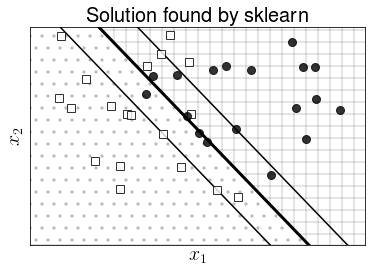

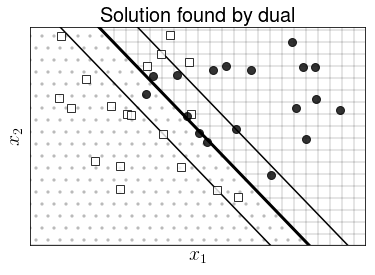

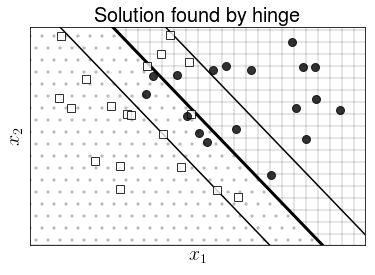

In [20]:
def myplot(X0, X1, w, b, filename, tit):
    with PdfPages(filename) as pdf:
        fig, ax = plt.subplots()

        w0 = w[0]
        w1 = w[1]
        x1 = np.arange(-10, 10, 0.1)
        y1 = -w0/w1*x1 - b/w1
        y2 = -w0/w1*x1 - (b-1)/w1
        y3 = -w0/w1*x1 - (b+1)/w1
        plt.plot(x1, y1, 'k', linewidth = 3)
        plt.plot(x1, y2, 'k')
        plt.plot(x1, y3, 'k')

        # equal axis and lim
        plt.axis('equal')
        plt.ylim(0, 3)
        plt.xlim(2, 4)

        # hide tikcs 
        cur_axes = plt.gca()
        cur_axes.axes.get_xaxis().set_ticks([])
        cur_axes.axes.get_yaxis().set_ticks([])

        # fill two regions
        y4 = 10*x1
        plt.plot(x1, y1, 'k')
        plt.fill_between(x1, y1,  hatch = '.', edgecolor="gray", facecolor = 'white', alpha = .4)
        plt.fill_between(x1, y1, y4, hatch = '+', edgecolor="gray", 
                         facecolor = 'white', alpha = .4)

        plt.xlabel('$x_1$', fontsize = 20)
        plt.ylabel('$x_2$', fontsize = 20)
        plt.title('Solution found by ' + tit, fontsize = 20)

        plt.plot(X0[:, 0], X0[:, 1], 'ws', mec = 'k', markersize = 8, alpha = .8)
        plt.plot(X1[:, 0], X1[:, 1], 'ko', markersize = 8, alpha = .8)
        pdf.savefig()
        plt.show()

myplot(X0, X1, w_sklearn, b_sklearn, 'svm_sklearn.pdf', 'sklearn')
myplot(X0, X1, w_dual, b_dual, 'svm_dual.pdf', 'dual')
myplot(X0, X1, w_hinge, b_hinge, 'svm_hinge.pdf', 'hinge')

In [19]:
print(w_sklearn.T, b_sklearn)
print(w_dual.T, b_dual) 
print(w_hinge.T, b_hinge)

[[-1.87461946 -1.80697358]] 8.496911901960104
[-1.87457279 -1.80695039] 8.496721098153419
[-1.37327856 -1.3207334 ] 6.480385170734615
